In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## BigARTM Model

In [2]:
!pip install -q bigartm

     |████████████████████████████████| 1.9 MB 5.2 MB/s 


In [3]:
from pprint import pprint
from typing import List

from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import artm

plt.rcParams['figure.figsize'] = (11, 5)
plt.rcParams['axes.grid'] = True

In [4]:
def draw_bar_plot(name, data, hline_value=None):
    print(name)
    ax = sns.barplot(
        x=list(data.keys()),
        y=list(data.values())
    )
    ax.axhline(hline_value or np.mean(list(data.values())))
    ax.set_ylabel(name)
    ax.set_xticklabels(list(data.keys()), rotation=45)
    return ax

In [5]:
# batch_vectorizer = artm.BatchVectorizer(
#     data_path='/content/drive/MyDrive/ОмГТУ/ВКР/Реализация/books/vowpal_wabbit/data.txt',
#     data_format='vowpal_wabbit',
#     target_folder='/content/drive/MyDrive/ОмГТУ/ВКР/Реализация/bigartm/batches'
# )
batch_vectorizer = artm.BatchVectorizer(
    data_path='/content/drive/MyDrive/ОмГТУ/ВКР/Реализация/bigartm/batches',
    data_format='batches'
)

In [6]:
dictionary = artm.Dictionary()
dictionary.gather(
    data_path='/content/drive/MyDrive/ОмГТУ/ВКР/Реализация/bigartm/batches'
)
print(dictionary)

artm.Dictionary(name=80f5deca-9425-45cc-9d53-c60de009a80f, num_entries=119796)


In [7]:
dictionary.filter(
    min_tf=3,
    max_tf=10000,
    min_df=2
)

artm.Dictionary(name=80f5deca-9425-45cc-9d53-c60de009a80f, num_entries=26308)

In [ ]:
from collections import Counter
from pprint import pprint


dct = '/content/drive/MyDrive/ОмГТУ/ВКР/Реализация/bigartm/dict/dictionary.txt'
with open(dct) as f:
    res = f.readlines()
res = map(lambda r: r.split(', '), map(str.strip, res[2:]))
# tokens_df = [float(r[-1]) for r in res]
tokens_tf = [float(r[-2]) for r in res]

# pprint(Counter(tokens_df))
pprint(sorted(tokens_tf, reverse=True)[:50])
# print(list(res)[0])

In [ ]:
dictionary.save_text(
    dictionary_path='/content/drive/MyDrive/ОмГТУ/ВКР/Реализация/bigartm/dict/dictionary.txt'
)

In [8]:
n_topics = 30
topic_names = [f'topic_{i}' for i in range(n_topics)]

### PLSA

In [ ]:
plsa = artm.ARTM(
    num_topics=n_topics,
    dictionary=dictionary,
    topic_names=topic_names,
    cache_theta=True,
    scores=[
        artm.PerplexityScore('perplexity_score', dictionary=dictionary),
        artm.SparsityPhiScore('sparsity_phi_score'),
        artm.SparsityThetaScore('sparsity_theta_score'),
        artm.TopTokensScore('top_tokens_score', num_tokens=100),
        artm.TopicKernelScore('topic_kernel', 
                              probability_mass_threshold=0.25)
    ]
)

In [ ]:
plsa.fit_offline(batch_vectorizer=batch_vectorizer, 
                 num_collection_passes=100)

#### Metrics

In [ ]:
print('Mean Size', 
      np.mean(plsa.score_tracker['topic_kernel'].average_size))
print('Mean Purity', 
      np.mean(plsa.score_tracker['topic_kernel'].average_purity))
print('Mean Contrast', 
      np.mean(plsa.score_tracker['topic_kernel'].average_contrast))

Mean Size 1085.207669107914
Mean Purity 0.1697696847381303
Mean Contrast 0.395086504034698


Size


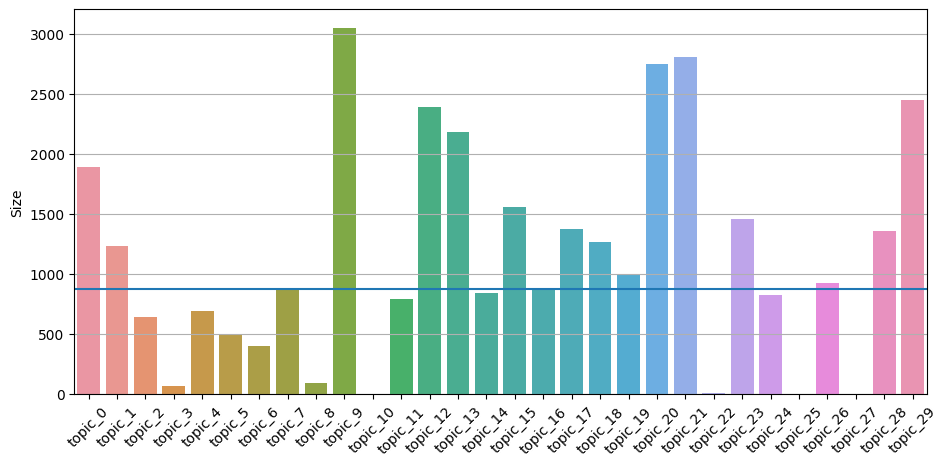

In [ ]:
draw_bar_plot('Size', 
              plsa.score_tracker['topic_kernel'].last_size,
              26308 / 30)

Contrast


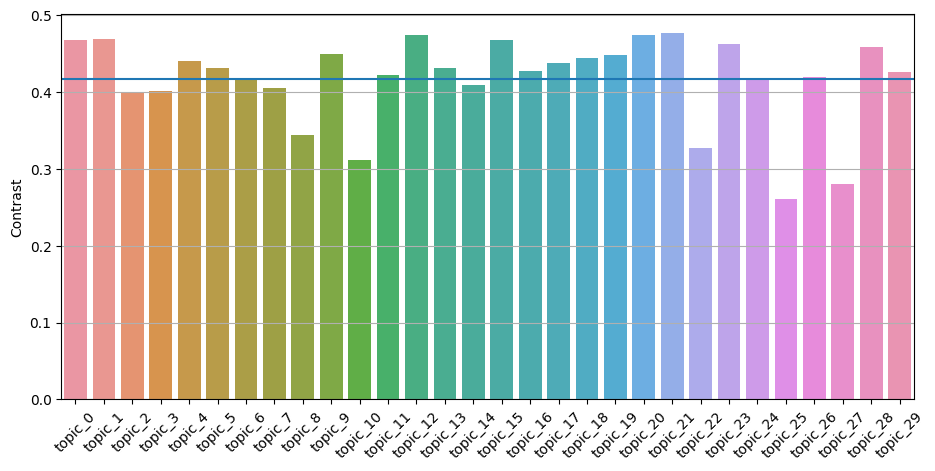

In [ ]:
draw_bar_plot('Contrast', 
              plsa.score_tracker['topic_kernel'].last_contrast)

Purity


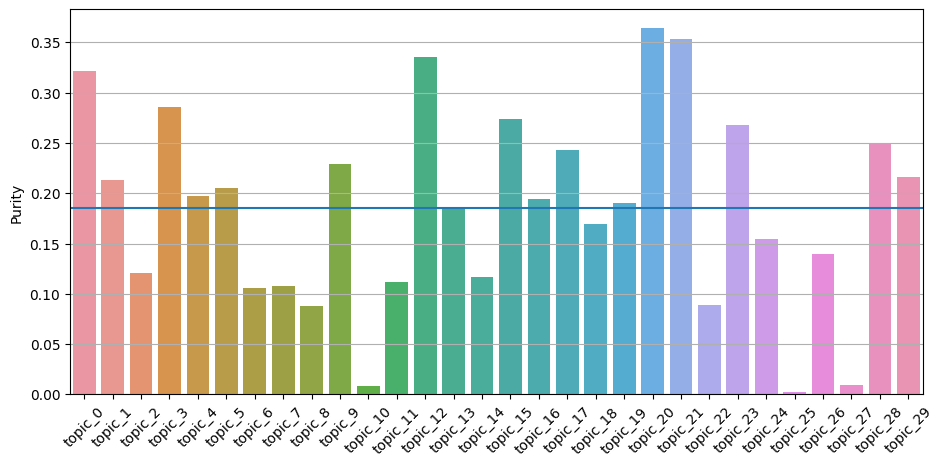

In [ ]:
draw_bar_plot('Purity', 
              plsa.score_tracker['topic_kernel'].last_purity)

PLSA 1675.992919921875


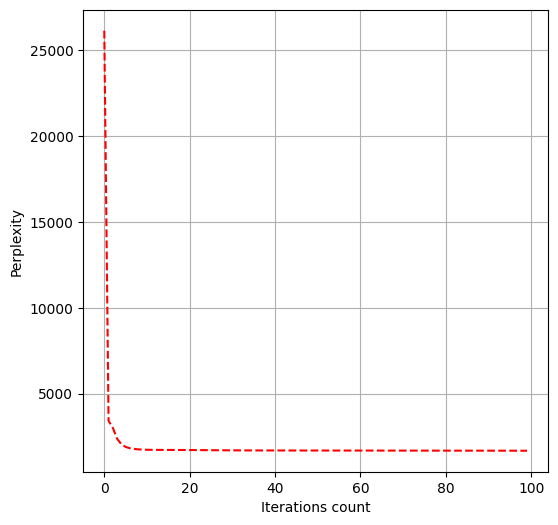

In [ ]:
print('PLSA', plsa.score_tracker['perplexity_score'].last_value)

plt.figure(figsize=(6, 6))
plt.plot(
    range(plsa.num_phi_updates),
    plsa.score_tracker['perplexity_score'].value,
    'r--'
)
plt.xlabel('Iterations count')
plt.ylabel('Perplexity')
plt.show()

PLSA
Phi: 0.74
Theta: 0.00


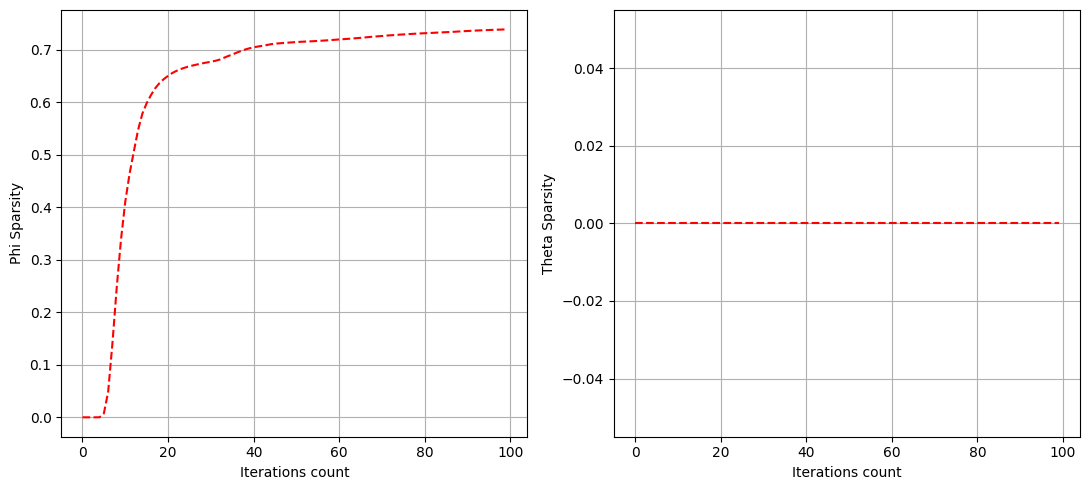

In [ ]:
print('PLSA', 
      f"Phi: {plsa.score_tracker['sparsity_phi_score'].last_value:.2f}",
      f"Theta: {plsa.score_tracker['sparsity_theta_score'].last_value:.2f}",
      sep='\n')

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].plot(
    range(plsa.num_phi_updates),
    plsa.score_tracker['sparsity_phi_score'].value,
    'r--'
)
axes[0].set_xlabel('Iterations count')
axes[0].set_ylabel('Phi Sparsity')

axes[1].plot(
    range(plsa.num_phi_updates),
    plsa.score_tracker['sparsity_theta_score'].value,
    'r--'
)
axes[1].set_xlabel('Iterations count')
axes[1].set_ylabel('Theta Sparsity')

fig.tight_layout()

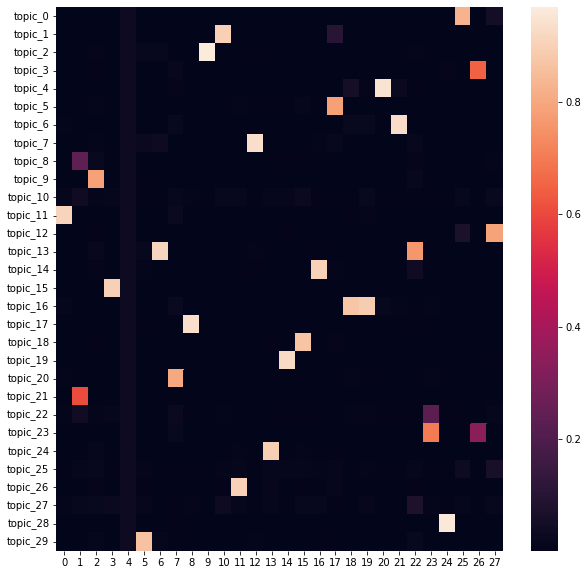

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    data=plsa.get_theta()
)

In [ ]:
saved_top_tokens = plsa.score_tracker['top_tokens_score'].last_tokens
for topic_name in saved_top_tokens:
    print(topic_name)
    print(saved_top_tokens[topic_name][:30])

topic_0
['python', 'экземпляр', 'атрибут', 'объект', 'имя', 'class', 'def', 'исключение', 'вызов', 'функция', 'декоратор', 'также', 'операция', 'аргумент', 'файл', 'новый', 'тип', 'self', 'версия', 'часть', 'name', 'инструмент', 'оператор', 'return', 'строка', 'наследование', 'пример', 'которые', 'первый', 'иметь']
topic_1
['объект', 'паттерн', 'операция', 'интерфейс', 'подкласс', 'реализация', 'void', 'virtual', 'структура', 'запрос', 'абстрактный', 'проектирование', 'состояние', 'вид', 'клиент', 'каждый', 'новый', 'например', 'пример', 'свой', 'экземпляр', 'поведение', 'конкретный', 'public', 'определить', 'должный', 'определять', 'система', 'class', 'итератор']
topic_2
['сайт', 'страница', 'пользователь', 'книга', 'человек', 'нужный', 'которые', 'должный', 'начальный', 'ваш', 'свой', 'каждый', 'хороший', 'тестирование', 'поиск', 'сделать', 'время', 'иметь', 'название', 'вопрос', 'навигация', 'использовать', 'слово', 'интернет', 'очень', 'например', 'ссылка', 'найти', 'первый', 'знат

### Sparsed ARTM

In [11]:
sparsed_artm = artm.ARTM(
    num_topics=n_topics,
    dictionary=dictionary,
    topic_names=topic_names,
    cache_theta=True,
    scores=[
        artm.PerplexityScore('perplexity_score', dictionary=dictionary),
        artm.SparsityPhiScore('sparsity_phi_score'),
        artm.SparsityThetaScore('sparsity_theta_score'),
        artm.TopTokensScore('top_tokens_score', num_tokens=100),
        artm.TopicKernelScore('topic_kernel', 
                              probability_mass_threshold=0.25)
    ],
    regularizers=[
        artm.SmoothSparsePhiRegularizer('sparse_phi_regularizer', 
                                        tau=-0.8),
        artm.SmoothSparseThetaRegularizer('sparse_theta_regularizer', 
                                          tau=-150)
    ]
)

In [12]:
sparsed_artm.fit_offline(batch_vectorizer=batch_vectorizer, 
                         num_collection_passes=100)

#### Metrics

In [ ]:
print('Mean Size', 
      np.mean(sparsed_artm.score_tracker['topic_kernel'].average_size))
print('Mean Purity', 
      np.mean(sparsed_artm.score_tracker['topic_kernel'].average_purity))
print('Mean Contrast', 
      np.mean(sparsed_artm.score_tracker['topic_kernel'].average_contrast))

Mean Size 553.5470001220704
Mean Purity 0.28432615051744503
Mean Contrast 0.5751300090551377


Size


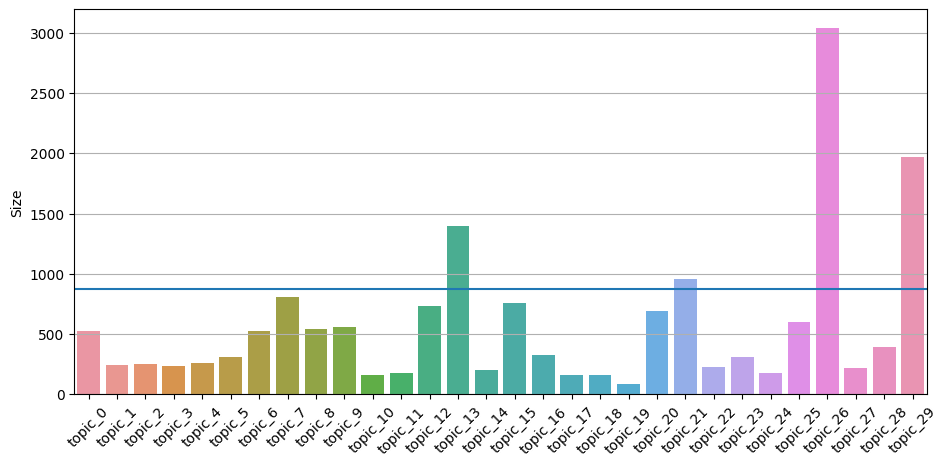

In [ ]:
draw_bar_plot('Size', 
              sparsed_artm.score_tracker['topic_kernel'].last_size,
              26308 / 30)

Contrast


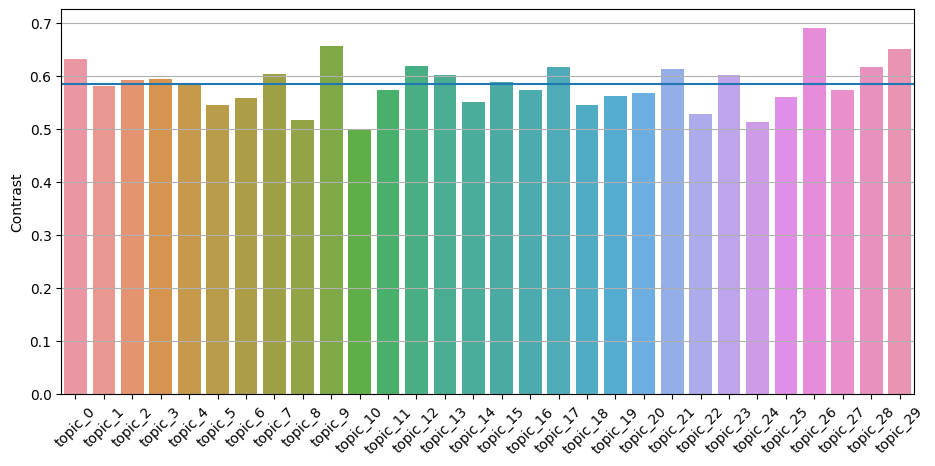

In [ ]:
draw_bar_plot('Contrast', 
              sparsed_artm.score_tracker['topic_kernel'].last_contrast)

Purity


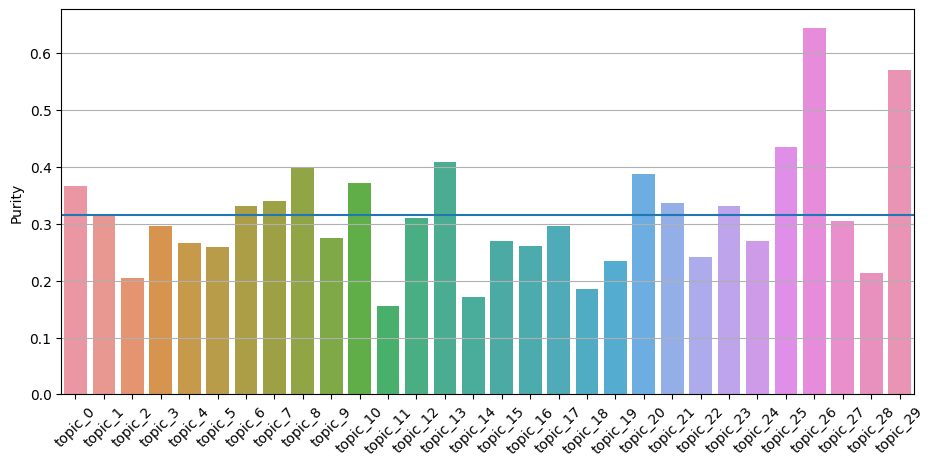

In [ ]:
draw_bar_plot('Purity', 
              sparsed_artm.score_tracker['topic_kernel'].last_purity)

Sparsed ARTM 1980.05712890625


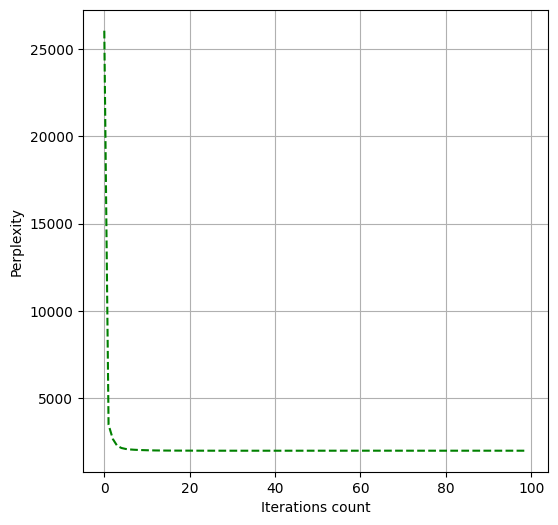

In [ ]:
print('Sparsed ARTM', sparsed_artm.score_tracker['perplexity_score'].last_value)

plt.figure(figsize=(6, 6))
plt.plot(
    range(sparsed_artm.num_phi_updates),
    sparsed_artm.score_tracker['perplexity_score'].value,
    'g--'
)
plt.xlabel('Iterations count')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

Sparsed ARTM
Phi: 0.93
Theta: 0.66


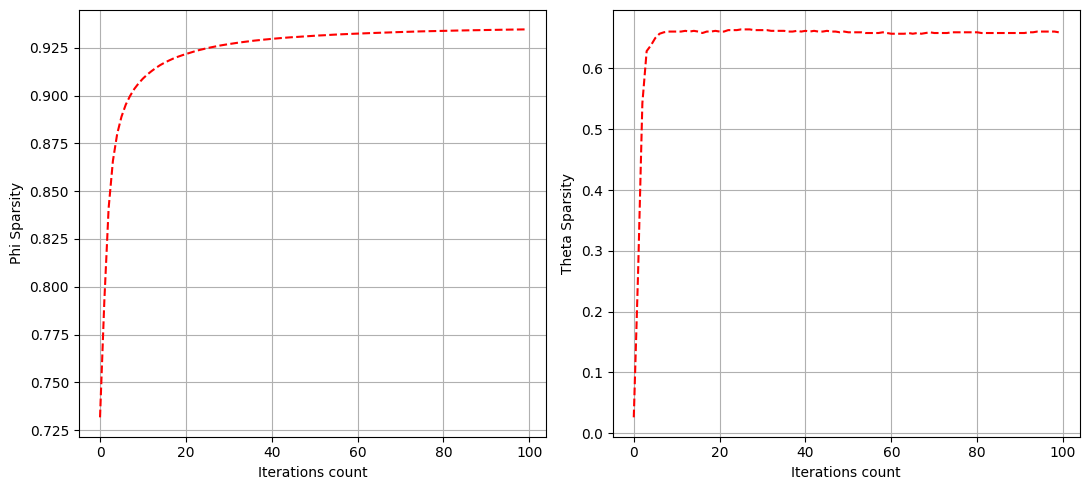

In [ ]:
print('Sparsed ARTM', 
      f"Phi: {sparsed_artm.score_tracker['sparsity_phi_score'].last_value:.2f}",
      f"Theta: {sparsed_artm.score_tracker['sparsity_theta_score'].last_value:.2f}",
      sep='\n')

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].plot(
    range(sparsed_artm.num_phi_updates),
    sparsed_artm.score_tracker['sparsity_phi_score'].value,
    'r--'
)
axes[0].set_xlabel('Iterations count')
axes[0].set_ylabel('Phi Sparsity')

axes[1].plot(
    range(sparsed_artm.num_phi_updates),
    sparsed_artm.score_tracker['sparsity_theta_score'].value,
    'r--'
)
axes[1].set_xlabel('Iterations count')
axes[1].set_ylabel('Theta Sparsity')

fig.tight_layout()

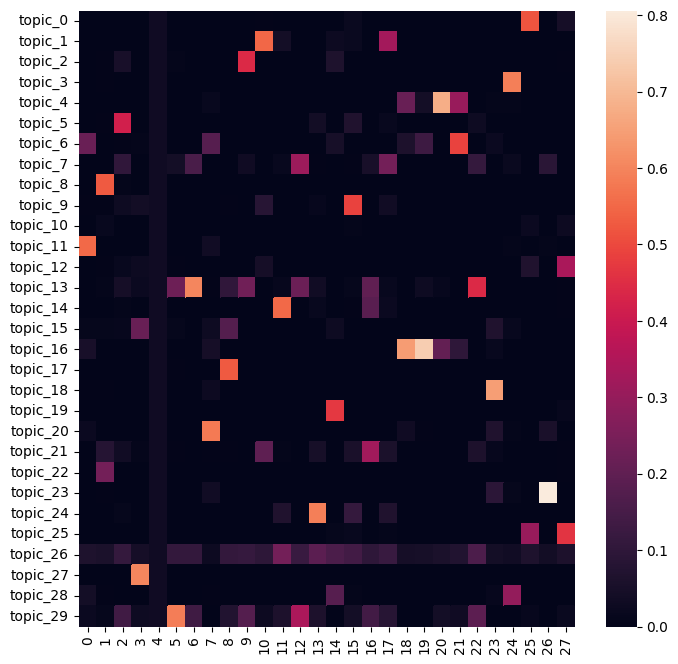

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(
    data=sparsed_artm.get_theta()
)

In [53]:
saved_top_tokens = sparsed_artm.score_tracker['top_tokens_score'].last_tokens
saved_weights = sparsed_artm.score_tracker['top_tokens_score'].last_weights
keywords_with_weights = []
for topic_name in saved_top_tokens:
    data = zip(saved_top_tokens[topic_name], saved_weights[topic_name])
    topic_kw = tuple({'word': word, 'weight': weight} for word, weight in data)
    index = int(topic_name.split('_')[-1])
    keywords_with_weights.append(
        {
            'index': index,
            'name': topic_name,
            'keywords': topic_kw
        }
    )

In [54]:
import json
from pathlib import Path


with open('/content/drive/MyDrive/ОмГТУ/ВКР/Реализация/keywords_with_weights.json', 'w') as f:
    json.dump(keywords_with_weights, f, ensure_ascii=False)

### ~Sparsed and Smoothed ARTM~

In [ ]:
black_topics = ['topic_26', 'topic_28', 'topic_29']
white_topics = [t for t in topic_names if t not in black_topics]

In [ ]:
sparsed_smoothed_artm = artm.ARTM(
    num_topics=n_topics,
    dictionary=dictionary,
    topic_names=topic_names,
    cache_theta=True,
    scores=[
        artm.PerplexityScore(name='perplexity_score', dictionary=dictionary),
        artm.SparsityPhiScore(name='sparsity_phi_score', 
                              topic_names=white_topics),
        artm.SparsityThetaScore(name='sparsity_theta_score',
                                topic_names=white_topics),
        artm.TopTokensScore(name='top_tokens_score', num_tokens=100)
    ],
    regularizers=[
        artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer', 
                                        tau=-10,
                                        topic_names=white_topics),
        artm.SmoothSparsePhiRegularizer(name='smooth_phi_regularizer', 
                                        tau=10,
                                        topic_names=black_topics),
        artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer', 
                                          tau=-25,
                                         topic_names=white_topics),
        artm.SmoothSparseThetaRegularizer(name='smooth_theta_regularizer', 
                                          tau=25,
                                          topic_names=black_topics),
        artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', 
                                        tau=1e+5)
    ]
    )

In [ ]:
sparsed_smoothed_artm.fit_offline(batch_vectorizer=batch_vectorizer, 
                                  num_collection_passes=10)

Sparsed & Smoothed ARTM 4390.13037109375


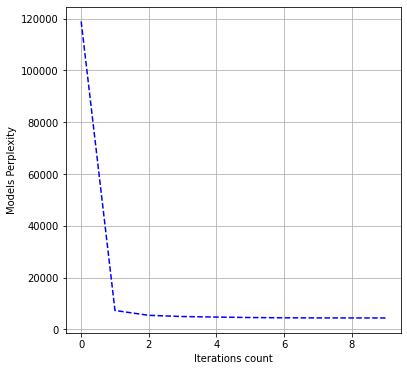

In [ ]:
print('Sparsed & Smoothed ARTM', sparsed_smoothed_artm.score_tracker['perplexity_score'].last_value)

plt.figure(figsize=(6, 6))
plt.plot(
    range(sparsed_smoothed_artm.num_phi_updates),
    sparsed_smoothed_artm.score_tracker['perplexity_score'].value,
    'b--'
)
plt.xlabel('Iterations count')
plt.ylabel('Models Perplexity')
plt.grid(True)
plt.show()

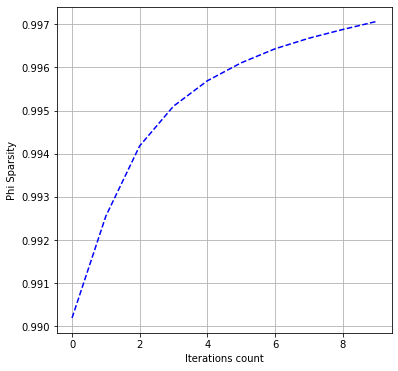

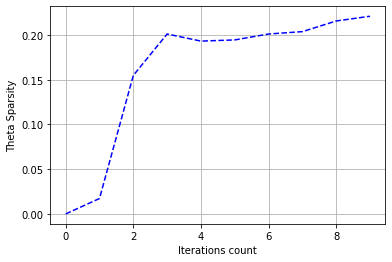

In [ ]:
plt.figure(figsize=(6, 6))

plt.plot(
    range(sparsed_smoothed_artm.num_phi_updates),
    sparsed_smoothed_artm.score_tracker['sparsity_phi_score'].value,
    'b--'
)

plt.xlabel('Iterations count')
plt.ylabel('Phi Sparsity')
plt.grid(True)
plt.show()

plt.plot(
    range(sparsed_smoothed_artm.num_phi_updates),
    sparsed_smoothed_artm.score_tracker['sparsity_theta_score'].value,
    'b--'
)

plt.xlabel('Iterations count')
plt.ylabel('Theta Sparsity')
plt.grid(True)
plt.show()

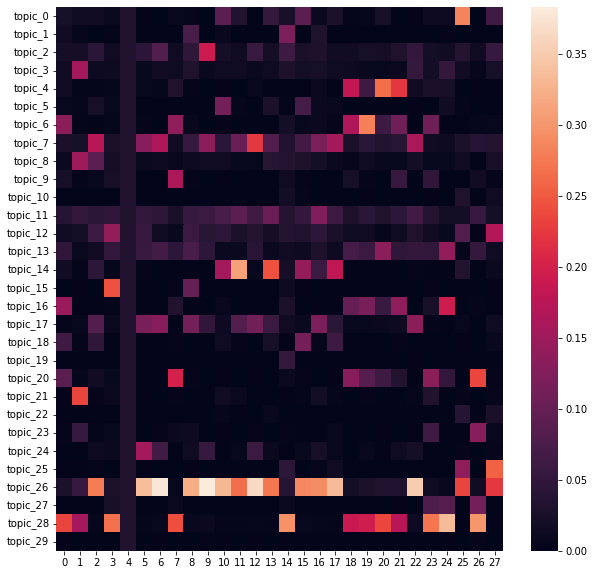

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    data=sparsed_smoothed_artm.get_theta()
)

In [ ]:
saved_top_tokens = sparsed_smoothed_artm.score_tracker['top_tokens_score'].last_tokens
for topic_name in saved_top_tokens:
    print(saved_top_tokens[topic_name])

['класс', 'экземпляр', 'метод', 'объект', 'мочь', 'class', 'исключение', 'атрибут', 'имя', 'операция', 'вызов', 'также', 'являться', 'новый', 'наследование', 'код', 'иметь', 'self', 'глава', 'весь', 'состояние', 'значение', 'return', 'аргумент', 'object', 'тип', 'def', 'пример', 'первый', 'версия', 'использование', 'каждый', 'которые', 'person', 'value', 'использовать', 'часть', 'реализовать', 'unicode', 'bob', 'который', 'try', 'ошибка', 'случай', 'хотя', 'отображение', 'извлечение', 'реализация', 'либо', 'автоматически', 'подкласс', 'super', 'контекст', 'предоставлять', 'поскольку', 'type', 'стандартный', 'поведение', 'следующий', 'применение', 'возвращать', 'работать', 'обычно', 'например', 'ранее', 'вызывать', 'привести', 'выполнение', 'работа', 'показать', 'любой', 'кодировка', 'файл', 'генерация', 'способный', 'использоваться', 'отличаться', 'связать', 'схема', 'байт', 'выполняться', 'символ', 'декоратор', 'instance', 'роль', 'дерево', 'создание', 'передавать', 'приложение', 'авт

In [ ]:
# FIX ME!!!
# scores_values = {
#     'plsa': {},
#     'sparsed_artm': {},
#     'sparsed_smoothed_artm': {}
# }

# score_names = ('perplexity_score', 'sparsity_phi_score', 
#                'sparsity_theta_score', 'top_tokens_score')
# models = (plsa, sparsed_artm, sparsed_smoothed_artm)
# for key in scores_values:
#     for score, model in zip(score_names, models):
#         if score == 'top_tokens':
#             values = model.score_tracker[score].last_tokens
#         else:
#             values = model.score_tracker[score].value
#         scores_values[key][score] = values

PLSA 2116.467529296875
Sparsed ARTM 3173.489013671875
Sparsed & Smoothed ARTM 2117.181884765625


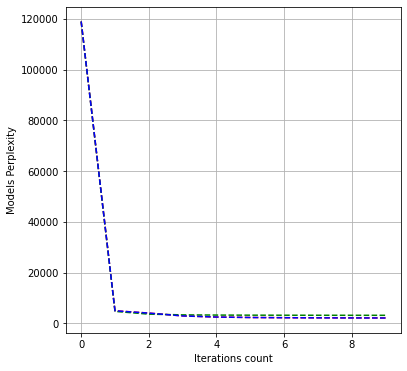

In [ ]:
import matplotlib.pyplot as plt



print('PLSA', plsa.score_tracker['perplexity_score'].last_value)
print('Sparsed ARTM', sparsed_artm.score_tracker['perplexity_score'].last_value)
print('Sparsed & Smoothed ARTM', sparsed_smoothed_artm.score_tracker['perplexity_score'].last_value)

plt.figure(figsize=(6, 6))
plt.plot(
    range(plsa.num_phi_updates),
    plsa.score_tracker['perplexity_score'].value,
    'r--',
    range(sparsed_artm.num_phi_updates),
    sparsed_artm.score_tracker['perplexity_score'].value,
    'g--',
    range(sparsed_smoothed_artm.num_phi_updates),
    sparsed_smoothed_artm.score_tracker['perplexity_score'].value,
    'b--'
)
plt.xlabel('Iterations count')
plt.ylabel('Models Perplexity')
plt.grid(True)
plt.show()

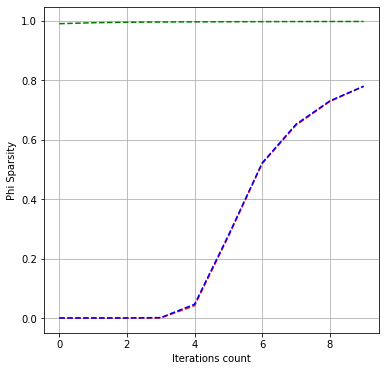

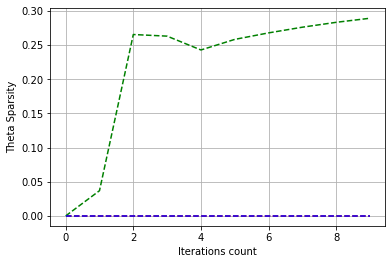

In [ ]:
plt.figure(figsize=(6, 6))

plt.plot(
    range(plsa.num_phi_updates),
    plsa.score_tracker['sparsity_phi_score'].value,
    'r--',
    range(sparsed_artm.num_phi_updates),
    sparsed_artm.score_tracker['sparsity_phi_score'].value,
    'g--',
    range(sparsed_smoothed_artm.num_phi_updates),
    sparsed_smoothed_artm.score_tracker['sparsity_phi_score'].value,
    'b--'
)

plt.xlabel('Iterations count')
plt.ylabel('Phi Sparsity')
plt.grid(True)
plt.show()

plt.plot(
    range(plsa.num_phi_updates),
    plsa.score_tracker['sparsity_theta_score'].value,
    'r--',
    range(sparsed_artm.num_phi_updates),
    sparsed_artm.score_tracker['sparsity_theta_score'].value,
    'g--',
    range(sparsed_smoothed_artm.num_phi_updates),
    sparsed_smoothed_artm.score_tracker['sparsity_theta_score'].value,
    'b--'
)

plt.xlabel('Iterations count')
plt.ylabel('Theta Sparsity')
plt.grid(True)
plt.show()

## Competences


In [34]:
import pickle

with open('/content/drive/MyDrive/ОмГТУ/ВКР/Реализация/competences_mapping.pickle', 'rb') as input:
    mapping = pickle.load(input)

In [ ]:
import os


comp_files_dir = '/content/drive/MyDrive/ОмГТУ/Диплом/competences'
base, _, filenames = next(os.walk(comp_files_dir))
comp_files = [os.path.join(base, filename) for filename in filenames]

In [ ]:
texts = []
for comp_file in comp_files:
    with open(comp_file, encoding='utf-8') as f:
        texts.append(
            (
                comp_file.rsplit('/', maxsplit=1)[-1].rsplit('.', maxsplit=1)[0],
                ' '.join(f.readlines())
            )
        )

In [ ]:
import re


regex = re.compile(r"(?:ОПК-\d\.).*?(?:(?: \d{1,2} )|(?: ОПК-\d))", 
                   re.MULTILINE)
matches = []
for code, text in texts:
    matches.append(
        (
            code, 
            [match.group() for match in re.finditer(regex, 
                                                    re.sub(r'\s+', ' ', text))]
        )
    )

In [ ]:
mapping = {}
for code, match in matches:
    mapping[code] = {}
    for comp in match:
        comp = re.sub(r'ИД-\d', '', comp)
        comp_code = comp.split('.', maxsplit=1)[0]
        if not comp_code in mapping[code]:
            mapping[code][comp_code] = {
                'знать': set(), 'уметь': set(), 'владеть': set()
            }
        first_split = comp.split('Знать')[1].split('Уметь')
        second_split = comp.split('Знать')[1].split('Уметь')[1].split('Владеть')

        to_know = re.sub(r'[:.]', '', first_split[0]).strip().split(';')
        to_able = re.sub(r'[:.]', '', second_split[0]).strip().split(';')
        to_own = re.sub(r'[:.]', '', second_split[1]).strip()[:-6].split(';')

        mapping[code][comp_code]['знать'].update(to_know)
        mapping[code][comp_code]['уметь'].update(to_able)
        mapping[code][comp_code]['владеть'].update(to_own)

In [ ]:
for track in mapping:
    for comp in mapping[track]:
        all_words = []
        for value in mapping[track][comp].values():
            all_words.extend(value)
        mapping[track][comp]['all_words'] = all_words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


top_n = 100
for track in mapping:
    for comp in mapping[track]:
        data = mapping[track][comp]['all_words']
        res = list(map(lambda sent: ' '.join(preprocess_text(sent)), data))
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(res)
        feature_names = np.array(vectorizer.get_feature_names_out())
        sorted_nzs = np.argsort(X.data)[:-(top_n + 1):-1]
        mapping[track][comp]['top_n'] = feature_names[X.indices[sorted_nzs]]

In [ ]:
import pprint
pprint.pprint(mapping)

In [ ]:
import pickle

with open('/content/drive/MyDrive/ОмГТУ/Диплом/competences_mapping.pickle', 'wb') as output:
    pickle.dump(mapping, output)

## Compare new competence and old competence

In [ ]:
!pip install -q sentence_transformers

     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 4.2 MB 48.4 MB/s 
     |████████████████████████████████| 1.2 MB 57.3 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 6.6 MB 50.2 MB/s 
     |████████████████████████████████| 596 kB 50.2 MB/s 


In [ ]:
from sentence_transformers import SentenceTransformer
from scipy.spatial import distance


model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
sentences = [
    'фундаментальные знания, полученные в области математических и (или) естественных наук, и использовать их в профессиональной деятельности.',
    'базовые знания естественных наук, математики и информатики, основные факты, концепции, принципы теорий, связанных с фундаментальной информатикой и информационными технологиями.',
    'современные языки программирования и языки баз данных, методологии системной инженерии, системы автоматизации проектирования, электронные библиотеки и коллекции, сетевые технологии, библиотеки и пакеты программ, современные профессиональные стандарты информационных технологий.'
]
sentence_embeddings = model.encode(sentences)

print(f'{distance.cosine(sentence_embeddings[0], sentence_embeddings[1]):.3f}')
print(f'{distance.cosine(sentence_embeddings[0], sentence_embeddings[2]):.3f}')

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

0.399
0.898


## Map topics and competences keywords

In [35]:
competences_keywords = [
    (f'{track} {comp}', mapping[track][comp]['top_n'])
    for track in mapping for comp in mapping[track]
]

top_tokens = saved_top_tokens
topic_keywords = list(top_tokens.values())

### IoU

In [36]:
!pip install navec
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-05-25 09:31:16--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.3MB/s    in 3.1s    

2022-05-25 09:31:20 (16.3 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [37]:
from navec import Navec

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

#### Выкладки по сопоставлению двух множеств ключевых слов

$C$ – ключевые слова компетенции;

$T$ – ключевые слова темы.

$C \cap T \neq T \cap C $, так как одно слово может иметь сразу несколько синонимов в другом множестве (ровно как и одно слово может являться синонимом для нескольких). Будем использовать $C \cap T$, так как мы подбираем ключевые слова именно для компетенции.

Алгоритм нахождения $|C \cap T|$ и $|C \cup T|$: находим $|C \cap T|$ через обычные прохождение по двум спискам с поиском синонимов; тогда $|C \cup T| = |C| + |T| - |C \cap T|$

$\theta = \widehat{(navec(c); navec(t))}$

$|C \cap T| = ∑_{c \in C, t \in T} cos(\theta) \le threshold$

$|C \cup T| = \begin{cases} 
|C| + ∑_{c \in C, t \in T} cos(\theta) > threshold, \text{if} \space \exists |C \cap T|; \\
|C| + |T| - |C \cap T|. \end{cases}$

In [38]:
def intersection_cardinality(lst1: List[str], lst2: List[str]) -> int:
    cardinality = 0
    for word1 in lst1:
        for word2 in lst2:
            if is_synonyms(word1, word2):
                cardinality += 1
                break
    return cardinality


def is_synonyms(word1: str, word2: str) -> bool:
    threshold = 0.6
    if word1 in navec and word2 in navec:
        return distance.cosine(navec[word1], navec[word2]) <= threshold
    return False


def union_cardinality(lst1: List[str], lst2: List[str], 
                      intersection_len=None) -> int:
    if intersection_len is not None:
        return len(lst1) + len(lst2) - intersection_len
    cardinality = len(lst1)
    for word1 in lst1:
        for word2 in lst2:
            if not is_synonyms(word1, word2):
                cardinality += 1
    return cardinality


def iou(lst1: List[str], lst2: List[str]) -> float:
    intersection_len = intersection_cardinality(lst1, lst2)
    return intersection_len / union_cardinality(lst1, lst2, intersection_len)

$iou\_values = |IoU(c_i, t_j)|_{|C| \times |T|}$, где $c_i \in C, i = \overline{1,|C|}$ и $t_j \in T, j = \overline{1,|T|}$

In [39]:
iou_values = np.array(
    [[iou(c, t) for t in topic_keywords] for _, c in competences_keywords]
)

In [ ]:
print(iou_values)

In [42]:
tracks = ['02.03.02', '02.03.03']
codes = ['ОПК-1', 'ОПК-2', 'ОПК-3', 'ОПК-4', 'ОПК-5', 'ОПК-6']
texts = [
    'Способен применять фундаментальные знания, полученные в области математических и (или) естественных наук, и использовать их в профессиональной деятельности',
    'Способен применять компьютерные/суперкомпьютерные методы, современное программное обеспечение, в том числе отечественного происхождения, для решения задач профессиональной деятельности',
    'Способен к разработке алгоритмических и программных решений в области системного и прикладного программирования, математических, информационных и имитационных моделей, созданию информационных ресурсов глобальных сетей, образовательного контента, прикладных баз данных, тестов и средств тестирования систем и средств на соответствие стандартам и исходным требованиям',
    'Способен участвовать в разработке технической документации программных продуктов и комплексов с использованием стандартов, норм и правил, а также в управлении проектами создания информационных систем на стадиях жизненного цикла',
    'Способен инсталлировать и сопровождать программное обеспечение информационных систем и баз данных, в том числе отечественного происхождения, с учетом информационной безопасности',
    'Способен применять фундаментальные знания, полученные в области математических и (или) естественных наук, и использовать их в профессиональной деятельности',
    'Способен применять современный математический аппарат, связанный с проектированием, разработкой, реализацией и оценкой качества программных продуктов и программных комплексов в различных областях человеческой деятельности',
    'Способен понимать и применять современные информационные технологии, в том числе отечественные, при создании программных продуктов и программных комплексов различного назначения',
    'Способен участвовать в разработке технической документации программных продуктов и программных комплексов',
    'Способен инсталлировать и сопровождать программное обеспечение для информационных систем и баз данных, в том числе отечественного производства',
    'Способен использовать в педагогической деятельности научные основы знаний в сфере информационно-коммуникационных технологий'
]

In [40]:
iou_values.shape

(11, 30)

In [44]:
competencies_with_topics = [
    {
        "track": '02.03.02',
        "code": 'ОПК-1',
        "text": None,
        "topic_indices": None
    },
    {
        "track": '02.03.02',
        "code": 'ОПК-2',
        "text": None,
        "topic_indices": None
    },
    {
        "track": '02.03.02',
        "code": 'ОПК-3',
        "text": None,
        "topic_indices": None
    },
    {
        "track": '02.03.02',
        "code": 'ОПК-4',
        "text": None,
        "topic_indices": None
    },
    {
        "track": '02.03.02',
        "code": 'ОПК-5',
        "text": None,
        "topic_indices": None
    },
    {
        "track": '02.03.03',
        "code": 'ОПК-1',
        "text": None,
        "topic_indices": None
    },
    {
        "track": '02.03.03',
        "code": 'ОПК-2',
        "text": None,
        "topic_indices": None
    },
    {
        "track": '02.03.03',
        "code": 'ОПК-3',
        "text": None,
        "topic_indices": None
    },
    {
        "track": '02.03.03',
        "code": 'ОПК-4',
        "text": None,
        "topic_indices": None
    },
    {
        "track": '02.03.03',
        "code": 'ОПК-5',
        "text": None,
        "topic_indices": None
    },
    {
        "track": '02.03.03',
        "code": 'ОПК-6',
        "text": None,
        "topic_indices": None
    }
]

In [51]:
for i in range(len(competencies_with_topics)):
    value = iou_values[i].argsort()[::-1]
    competencies_with_topics[i]['text'] = texts[i]
    competencies_with_topics[i]['topic_indices'] = tuple(map(int, value))

In [52]:
with open('/content/drive/MyDrive/ОмГТУ/ВКР/Реализация/competencies_with_topics.json', 'w') as f:
    json.dump(competencies_with_topics, f, ensure_ascii=False)

In [ ]:
pprint(topics_for_comp)

{'02.03.02 ОПК-1': array([23,  3, 28, 21,  5,  7, 20, 18,  6, 15,  1,  8, 26, 19, 11, 14, 27,
       16,  4, 22,  9, 13, 12, 25,  2, 29, 24, 10,  0, 17]),
 '02.03.02 ОПК-2': array([29,  5, 14, 13, 19,  1, 24, 22,  9, 25, 23, 21,  7, 15, 27,  3, 12,
        6, 28, 16,  8, 11, 18,  2, 17,  0,  4, 10, 20, 26]),
 '02.03.02 ОПК-3': array([ 7,  5, 13, 14,  3, 21,  8, 29,  1, 24, 19, 27, 25, 16, 12, 28, 11,
        2,  4,  9, 22, 18,  6, 23, 15, 10, 26, 20,  0, 17]),
 '02.03.02 ОПК-4': array([ 1, 13,  3,  7, 21,  5,  8, 28, 12, 29, 10, 11, 14, 27, 19, 22, 25,
        0,  6, 18,  9,  2, 26, 16, 23, 15, 20, 24,  4, 17]),
 '02.03.02 ОПК-5': array([ 1, 14,  2, 25, 13, 24,  5, 21,  7,  8,  9,  3, 12, 29, 19, 22, 28,
       20, 27, 15, 17, 10,  0, 16,  4, 11, 26, 18,  6, 23]),
 '02.03.03 ОПК-1': array([23,  3, 28, 21,  5,  7, 20, 18,  6, 15,  1,  8, 26, 19, 11, 14, 27,
       16,  4, 22,  9, 13, 12, 25,  2, 29, 24, 10,  0, 17]),
 '02.03.03 ОПК-2': array([ 5,  7, 14, 13,  3,  1, 29, 24, 21, 27, 19, 

In [ ]:
for k in topics_for_comp:
    print(k)
    pprint(
        saved_top_tokens['topic_' + str(topics_for_comp[k][0])][:15]
    )

02.03.02 ОПК-4
['объект',
 'public',
 'паттерн',
 'операция',
 'void',
 'return',
 'int',
 'private',
 'new',
 'интерфейс',
 'подкласс',
 'string',
 'реализация',
 'функция',
 'имя']
02.03.02 ОПК-1
['cid',
 'функция',
 'распределение',
 'вероятность',
 'случайный',
 'величина',
 'оценка',
 'иметь',
 'событие',
 'параметр',
 'случай',
 'точка',
 'теорема',
 'любой',
 'число']
02.03.02 ОПК-2
['программа',
 'язык',
 'работать',
 'программирование',
 'нужный',
 'делать',
 'знать',
 'очень',
 'говорить',
 'сделать',
 'программист',
 'писать',
 'время',
 'просто',
 'система']
02.03.02 ОПК-3
['должный',
 'тест',
 'функция',
 'система',
 'правило',
 'группа',
 'оценка',
 'свой',
 'ошибка',
 'день',
 'время',
 'ваш',
 'комментарий',
 'цель',
 'количество']
02.03.02 ОПК-5
['объект',
 'public',
 'паттерн',
 'операция',
 'void',
 'return',
 'int',
 'private',
 'new',
 'интерфейс',
 'подкласс',
 'string',
 'реализация',
 'функция',
 'имя']
02.03.03 ОПК-4
['объект',
 'public',
 'паттерн',
 'операция

In [ ]:
# indent = 6
# prec = 0.4

# for elem in range(n_topics):
#     print(f'{elem: >{indent}}', end=' ')
# print(f"{'max': <{indent}}")
# for comp in competences_keywords:
#     iou_values = [
#         (idx, iou(comp, topic))
#         for idx, topic in enumerate(topic_keywords, start=1)
#     ]

#     for _, iou_value in iou_values:
#         print(f'{iou_value:{prec}f}', end=' ')
    
#     top_max = sorted(iou_values, key=lambda t: t[1])[-5:]
#     top_max_topics = [str(t[0]) for t in top_max]
#     print(
#         f"{', '.join(top_max_topics): <{indent + 10}}"
#     )

### BERT

In [ ]:
!pip install -q sentence_transformers

     |████████████████████████████████| 79 kB 3.1 MB/s 
     |████████████████████████████████| 4.0 MB 11.4 MB/s 
     |████████████████████████████████| 1.2 MB 57.3 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 596 kB 52.6 MB/s 
     |████████████████████████████████| 6.6 MB 40.4 MB/s 
     |████████████████████████████████| 880 kB 48.3 MB/s 


In [ ]:
from sentence_transformers import SentenceTransformer
from scipy.spatial import distance


model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
data = [' '.join(competences_keywords[0])] + [' '.join(kw) for kw in topic_keywords]
embeddings = model.encode(data)

for embedded_topic in embeddings[1:]:
    print(f'{distance.cosine(embeddings[0], embedded_topic):.3f}')

0.849
0.882
0.992
0.960
0.806
0.758
0.789
0.822
0.881
0.884
0.927
0.831
0.764
0.775
0.916
0.863
0.846
0.900
0.853
0.862
0.840
0.920
0.965
1.029
0.927
0.697
0.945
0.850
0.783


## Synonyms

### `navec`

In [ ]:
!pip install navec
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [ ]:
from navec import Navec


path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

### w2v + ruwikiruscorpora

Нет смысла использовать, так как `navec` работает лучше любого RusVectores